# Test Noise Generator

Generate batch of noise and compute LTAS statistics.

Additionally, generate a longer sample of noise for listening

### Imports

In [8]:
import torch
import glob
import os
import torchaudio
import numpy as np
import soundfile as sf
import sounddevice as sd
import matplotlib.pyplot as plt
import matplotlib as mpl

from utilities.utilities import Eloi_Prettyfier as Prettyfier
from model import DiffusionGenerator
from omegaconf import OmegaConf
from utilities.utilities import smooth_spectrum

### Setup

In [9]:
# Global
RESULTS_PATH = "../results/"
DATA_PATH = "../audio/"
SAVE_FIGS = True
# DATA_PATH = /u/25/molinee2/unix/triton_work_asp/neural-tape-audio/

# Batch
fs = 44100
BATCH_SIZE = 128
SAMPLE_LENGTH = 65536

### Noise Generation

Create noise generator and sample batch

In [10]:
# Create generator
args = OmegaConf.load("../configs/conf_noise.yaml")
args.diff_params.T = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

generator = DiffusionGenerator(args, device)

# Generate noise
pred_batch = generator.sample_batch(BATCH_SIZE)
print(f"Generated trajectories (batch): {pred_batch.shape}")

dict_keys(['it', 'network', 'optimizer', 'ema', 'args'])
Generated trajectories (batch): torch.Size([128, 65536])


### Real noise

Sample batch of real noise

In [11]:
path_real_trajectories = f"{DATA_PATH}Silence_AKAI_IPS[7.5]_MAXELL_SPLIT/Train"

# Load all wav files in the directory
orig_p = os.getcwd()
os.chdir(path_real_trajectories)
filelist = glob.glob("*.wav")
filelist = [os.path.join(path_real_trajectories, f) for f in filelist]
test_file = filelist[0]
os.chdir(orig_p)

# Sample batch
batch = torch.zeros((BATCH_SIZE, SAMPLE_LENGTH), device="cpu")
j = 0
while j < BATCH_SIZE:
    for a in filelist:
        if j >= BATCH_SIZE:
            break
        print(f"Processing {j+1}/{BATCH_SIZE} ...", end='\r')
        x, fs_file = sf.read(a)

        # Downsample to 100 Hz
        x = torch.from_numpy(x)
        if fs_file != fs:
            x = torchaudio.functional.resample(x, fs_file, fs)

        # Crop a 512 samples chunk
        for k in range(4):
            i = torch.randint(0, x.shape[0] - SAMPLE_LENGTH, (1,))
            batch[j] = x[i:i + SAMPLE_LENGTH]
            j += 1
print(f"Processing {j}/{BATCH_SIZE} ... Done!")

batch = batch

print(f"Real trajectories: {batch.shape}")

Processing 128/128 ... Done!
Real trajectories: torch.Size([128, 65536])


### Visualizations

Compute statistics

In [12]:
def LTAS(batch):
    """Compute the LTAS of a batch of trajectories."""
    # Setup
    batch_size = batch.shape[0]
    length = batch.shape[1]

    # Compute
    LTAS_batch = torch.zeros((batch_size, length // 2 + 1), device="cpu")
    freqs = torch.fft.rfftfreq(length, d=1 / fs)
    for i in range(batch_size):
        print(f"Processing {i+1}/{batch_size} ...", end='\r')
        a = (torch.abs(torch.fft.rfft(batch[i])))
        a = a.numpy()
        LTAS_batch[i] = torch.from_numpy(smooth_spectrum(a, freqs.numpy(), 6))

        # This is super slow, it could be parallelized but I was lazy
        # now do the average smooth spectrum

        # print(LTAS_batch.shape, freqs.shape)
        # LTAS_batch=torch.from_numpy(LTAS_batch)

    LTAS_batch_mean = (LTAS_batch.mean(0))
    LTAS_std_top = LTAS_batch_mean + LTAS_batch.std(0)
    LTAS_std_bottom = LTAS_batch_mean - LTAS_batch.std(0)

    #now smooth the result
    #LTAS_batch=torch.nn.functional.avg_pool1d(LTAS_batch.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=2, ceil_mode=False).squeeze()
    #now in dB
    #LTAS_batch_mean=20*torch.log10(LTAS_batch_mean)
    #LTAS_batch_std=20*torch.log10(LTAS_std)

    return 20 * torch.log10(LTAS_batch_mean), 20 * torch.log10(
        LTAS_std_top), 20 * torch.log10(LTAS_std_bottom)


print("Computing LTAS for generated noise.")
LTAS_mean, LTAS_std_up, LTAS_std_bottom = LTAS(batch)
print("Computing LTAS for sampled noise.")
pred_LTAS_mean, pred_LTAS_std_up, pred_LTAS_std_bottom = LTAS(pred_batch)

Computing LTAS for generated noise.
Computing LTAS for sampled noise.


In [13]:
# Normalize range
LTAS_mean -= 10
LTAS_std_up -= 10
LTAS_std_bottom -= 10
pred_LTAS_mean -= 10
pred_LTAS_std_bottom -= 10
pred_LTAS_std_up -= 10

Visualize statistics

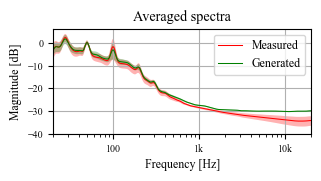

In [15]:
# SETUP

FIG_MULTIPLIER = 0.75
COLS = 1
ROWS = 1
RATIO = (1.75, 1)
NFFT = int(2**15)
PLOT_BATCH_SIZE = 4
labels_input = ["input, L", "input, R"]
labels_target = ["output, L", "output, R"]

prettyfier = Prettyfier(mode="paper_1col", ratio=RATIO)
prettyfier.font_size *= 0.95

ALPHA = prettyfier.alpha
DB_LIMS = prettyfier.db_lims

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

gs = plt.GridSpec(ROWS, COLS)

plt.rcParams['font.family'] = prettyfier.font_type
plt.rcParams['font.size'] = prettyfier.font_size
plt.rcParams['axes.labelsize'] = prettyfier.font_size * 6.0 / 6.0
plt.rcParams['xtick.labelsize'] = prettyfier.font_size * 5 / 6.0
plt.rcParams['ytick.labelsize'] = prettyfier.font_size * 5 / 6.0
plt.rcParams['lines.linewidth'] = prettyfier.line_width * 0.5

# Start plotting
t = np.arange(0, batch.shape[-1] / fs, 1 / fs)
f = np.arange(0, fs / 2, fs / SAMPLE_LENGTH)

FIG_MULTIPLIER = 1
fig = plt.figure(0, (prettyfier.fig_size[0] * FIG_MULTIPLIER,
                     prettyfier.fig_size[1] * FIG_MULTIPLIER))
fig.clf()

# Real
mu = LTAS_mean[0:-1].flatten().numpy()
sigma_bottom = LTAS_std_bottom[0:-1].flatten().numpy()
sigma_up = LTAS_std_up[0:-1].flatten().numpy()

ax = fig.add_subplot(gs[0, 0])

ax.plot(f, mu, color="red", label="Measured")
ax.fill_between(f, sigma_up, sigma_bottom, facecolor='red', alpha=0.3)

# Generated
mu = pred_LTAS_mean[0:-1].flatten().numpy()
sigma_up = pred_LTAS_std_up[0:-1].flatten().numpy()
sigma_bottom = pred_LTAS_std_bottom[0:-1].flatten().numpy()

ax.plot(f, mu, color="green", label="Generated")
ax.fill_between(f, sigma_up, sigma_bottom, facecolor='green', alpha=0.3)

ax.set_title('Averaged spectra')

ax.set_ylabel('Magnitude [dB]')
ax.set_ylim(-40, 6)

ax.set_xlabel('Frequency [Hz]')
ax.set_xscale("log")
ax.set_xlim(20, 20000)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
x_ticks = ax.get_xticks()
ax.set_xticks([100, 1000, 10000], ["100", "1k", "10k"])

ax.legend(loc='upper right')

ax.grid()

plt.tight_layout()

plt.show()

if SAVE_FIGS:
    fig.savefig("../results/noise_spectra.pdf", bbox_inches='tight') # PDF
    fig.savefig("../results/noise_spectra.png", bbox_inches='tight') # PNG

### Sound Example

Generate sound example

In [29]:
pred = generator.sample_long(20)
print(pred.shape)

test schedule tensor([0.0000e+00, 5.0000e-05, 1.0392e-04, 2.0546e-04, 3.8893e-04, 7.0858e-04,
        1.2478e-03, 2.1319e-03, 3.5443e-03, 5.7494e-03, 9.1206e-03, 1.4177e-02,
        2.1629e-02, 3.2439e-02, 4.7889e-02, 6.9672e-02, 1.0000e-01])
torch.Size([1, 882000])


### Listen to example

In [34]:
sd.play(pred[0], 44100) # original

# sd.play(0.25 * pred[0]/max((pred[0])), fs) # normalized